<a href="https://colab.research.google.com/github/dg7s/Deep_learning_tensorflow/blob/main/Food_vision_Food_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-27609b92-8024-b2a8-0f6e-b1128dfad76f)


## Import helper **functions**

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-30 17:44:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-30 17:44:08 (94.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                                    shuffle_files=True,
                                                    as_supervised=True, # data gets returned in tuple format (data, label),
                                                    with_info=True)

In [ ]:
# Feature of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 Datasets

In [ ]:
# Take one sample of train data
train_one_sample = train_data.take(1) # samples in format (image_tensor, label)

In [ ]:
# Output info about training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 23
  Class name (str form): churros
  


In [ ]:
# What does image tensor look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[189, 165, 121],
        [185, 161, 117],
        [181, 157, 113],
        ...,
        [111,  72,  33],
        [103,  64,  25],
        [ 94,  55,  16]],

       [[186, 162, 118],
        [183, 159, 115],
        [180, 156, 112],
        ...,
        [122,  83,  40],
        [113,  74,  31],
        [105,  66,  23]],

       [[180, 156, 112],
        [178, 154, 110],
        [177, 153, 109],
        ...,
        [132,  94,  45],
        [124,  87,  35],
        [120,  83,  31]],

       ...,

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [231, 225, 191],
        [231, 225, 189],
        [231, 226, 188]],

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [230, 224, 190],
        [230, 224, 188],
        [229, 223, 187]],

       [[206, 203, 158],
        [204, 200, 153],
        [203, 195, 146],
        ...,
        [229, 223, 18

In [ ]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot the image

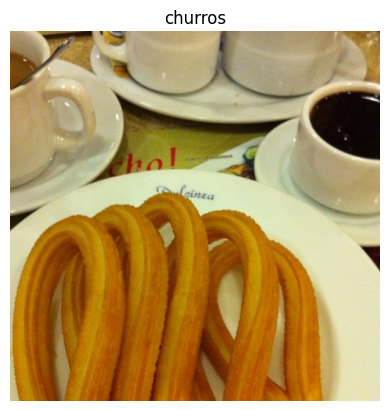

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=(224)):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channel]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple


In [ ]:
# Preprocess a single sample
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]} \nShape{image.shape}.\nDatatpye: {image.dtype}\n")

print(f"Image adter preprocessing:\n {preprocessed_img[:2]} \nShape{preprocessed_img.shape}.\nDatatpye: {preprocessed_img.dtype}\n")

Image before preprocessing:
 [[[189 165 121]
  [185 161 117]
  [181 157 113]
  ...
  [111  72  33]
  [103  64  25]
  [ 94  55  16]]

 [[186 162 118]
  [183 159 115]
  [180 156 112]
  ...
  [122  83  40]
  [113  74  31]
  [105  66  23]]] 
Shape(512, 512, 3).
Datatpye: <dtype: 'uint8'>

Image adter preprocessing:
 [[[184.91327  160.91327  116.91326 ]
  [180.35715  156.35715  112.35714 ]
  [183.71428  160.71428  118.71429 ]
  ...
  [147.5915   108.66289   69.08129 ]
  [123.576454  84.576454  44.198887]
  [106.44359   67.44359   25.872158]]

 [[174.66837  150.66837  106.668365]
  [175.14285  151.14285  107.14286 ]
  [177.80103  153.22958  112.015305]
  ...
  [155.61722  119.545784  68.443695]
  [145.1989   108.19381   53.423363]
  [134.37747   98.30605   40.73462 ]]] 
Shape(224, 224, 3).
Datatpye: <dtype: 'float32'>



## Batch & prepare datasets

In [ ]:
# Map preprocessing function to trainig
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

In [ ]:
# Create ModelCheckpoint callback
checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [ ]:
mixed_precision.global_policy

<function keras.src.mixed_precision.policy.global_policy()>

## Build feature extraction model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional modal
inputs = layers.Input(shape=input_shape, name="input_layer") # EfficientNet have rescaling built-in
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype polices

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_4 False float32 <Policy "mixed_float16">
normalization_2 False float32 <Policy "mixed_float16">
rescaling_5 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

## Fit the feature extraction model

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[model_checkpoint])

Epoch 1/3
2368/2368 [==============================] - 207s 83ms/step - loss: 1.7148 - accuracy: 0.5840 - val_loss: 1.1309 - val_accuracy: 0.6986
Epoch 2/3
2368/2368 [==============================] - 191s 80ms/step - loss: 1.1990 - accuracy: 0.6895 - val_loss: 1.0368 - val_accuracy: 0.7185
Epoch 3/3
2368/2368 [==============================] - 200s 83ms/step - loss: 1.0537 - accuracy: 0.7237 - val_loss: 0.9980 - val_accuracy: 0.7328


In [ ]:
# Evaluate model on whole test data
results_feature_extract_model = model.evaluate(test_data)

790/790 [==============================] - 51s 64ms/step - loss: 0.9970 - accuracy: 0.7273


## Save our model to file

In [ ]:
# Save our model
SAVE_DIR = "drive/MyDrive/tensorflow_course/101_food_classes_main_model"

os.makedirs(SAVE_DIR)
model.save(SAVE_DIR)

In [ ]:
# Load saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_main_model")

In [ ]:
results_loaded_model = loaded_model.evaluate(test_data)

790/790 [==============================] - 65s 76ms/step - loss: 0.9970 - accuracy: 0.7273


In [ ]:
for layer in loaded_model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Fine-tuning and Weights & Biases visualization

In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=e4b3e5e65e2438c44d14760cfeef429355346e1bba44d03ea478c8d946efc295
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import wandb
wandb.login()


from wandb.keras import WandbMetricsLogger


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
# Set all layers to be trainable
for layer in loaded_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in loaded_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 True float32 <Policy "float32">
rescaling_4 True float32 <Policy "mixed_float16">
normalization_2 True float32 <Policy "mixed_float16">
rescaling_5 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_f

In [ ]:
# Setup EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

chekpoint_path = "fine_tuned_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                            save_best_only=True,
                                            monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [ ]:
# Recompile model with 10x lower learning rate
loaded_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.00001),
              metrics=["accuracy"])

In [ ]:
# Initialize a W&B run
run = wandb.init(
    project = "101_food_vision",

    config = dict(num_classes = 101,
                  shuffle_buffer = 1024,
                  batch_size = 32,
                  image_size = 224,
                  image_channels = 1,
                  earlystopping_patience = 3,
                  learning_rate = 1e-3,
                  epochs = 100
              )
)

history_loaded_model_fine_tune = loaded_model.fit(train_data,
                                                  epochs=100,
                                                  steps_per_epoch=len(train_data),
                                                  validation_data=test_data,
                                                  validation_steps=int(0.15 * len(test_data)),
                                                  # initial_epoch=history_101_food_classes_feature_extract.epoch[-1], # without prevoius model it won't work
                                                  callbacks=[model_checkpoint,
                                                             early_stopping,
                                                             reduce_lr,
                                                             WandbMetricsLogger(log_freq="batch")])

# Close the W&B run
run.finish()

Epoch 1/100
2368/2368 [==============================] - 397s 166ms/step - loss: 0.3744 - accuracy: 0.9077 - val_loss: 0.8415 - val_accuracy: 0.7820 - lr: 2.0000e-06
Epoch 2/100
2368/2368 [==============================] - 404s 170ms/step - loss: 0.3629 - accuracy: 0.9105 - val_loss: 0.8511 - val_accuracy: 0.7834 - lr: 2.0000e-06
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.3513 - accuracy: 0.9138
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
2368/2368 [==============================] - 406s 170ms/step - loss: 0.3513 - accuracy: 0.9138 - val_loss: 0.8661 - val_accuracy: 0.7802 - lr: 2.0000e-06
Epoch 4/100
2368/2368 [==============================] - 389s 163ms/step - loss: 0.3371 - accuracy: 0.9183 - val_loss: 0.8654 - val_accuracy: 0.7815 - lr: 4.0000e-07


In [ ]:
# Evaluate our model
loaded_model.evaluate(test_data)

NameError: ignored

In [ ]:
# Save our model
SAVE_DIR = "drive/MyDrive/tensorflow_course/101_food_classes_main_model_fine_tuned_EfficientNetB0"

import os

#os.makedirs(SAVE_DIR)
loaded_model.save(SAVE_DIR)

In [ ]:
#import model
loaded_model_fine_tuned = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_main_model_fine_tuned_EfficientNetB0")

In [ ]:
# Evaluate our model
loaded_model_fine_tuned.evaluate(test_data)

790/790 [==============================] - 63s 76ms/step - loss: 0.8404 - accuracy: 0.7816


[0.8404313325881958, 0.7815841436386108]

In [ ]:
import matplotlib.pyplot as plt

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(20, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

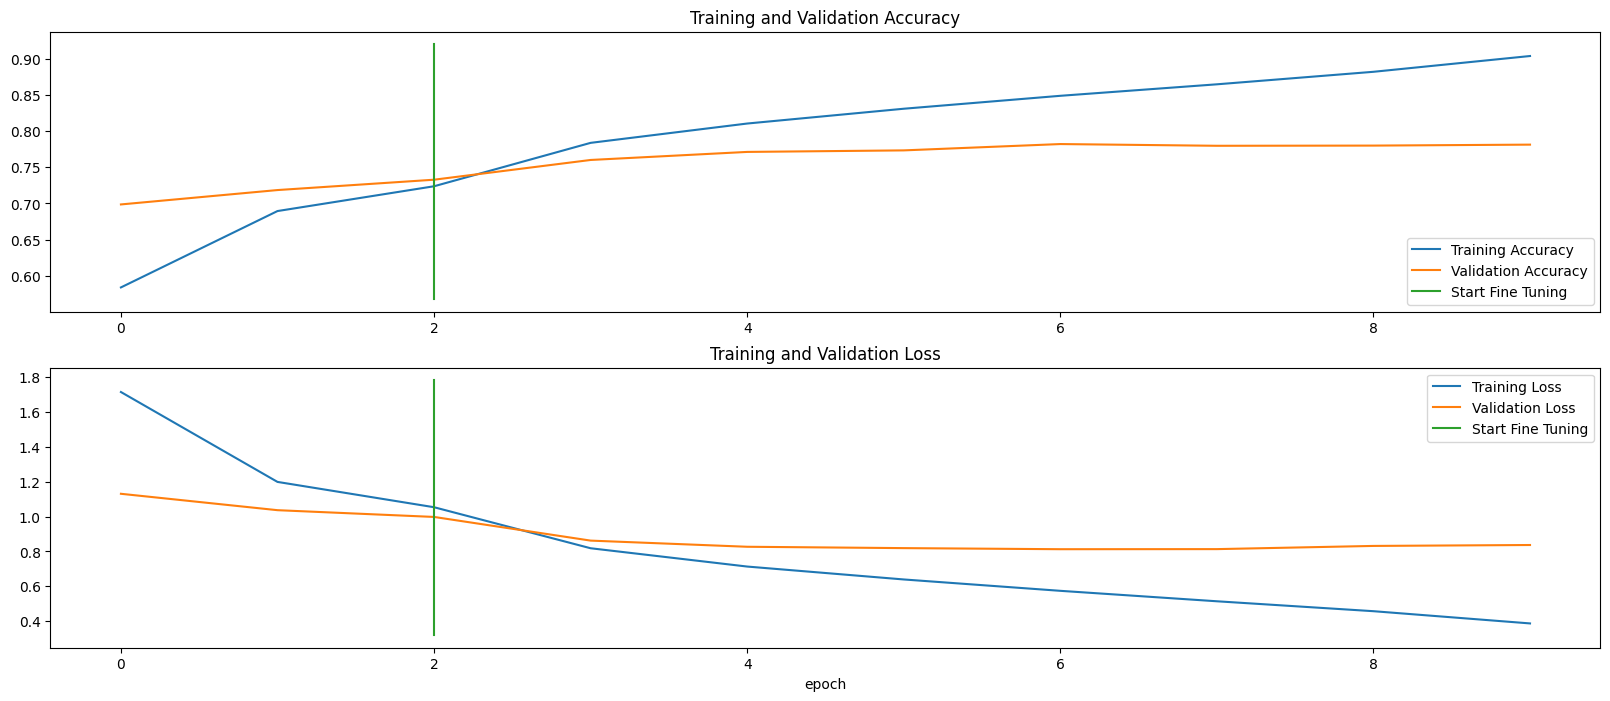

In [ ]:
# Compare the histories of feature extraction model with fine-tuningbiases
compare_historys(original_history = history_101_food_classes_feature_extract,
                new_history = history_loaded_model_fine_tune,
                 initial_epochs=3)

## Alternative model - this time with EfficientNetB4

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

# Create functional modal
inputs = layers.Input(shape=input_shape, name="input_layer") # EfficientNet have rescaling built-in
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
modelb4 = tf.keras.Model(inputs, outputs)

# Compile model
modelb4.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
modelb4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, None, None, 1792   17673823  
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

NameError: ignored

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract_b4 = modelb4.fit(train_data,
                                                      epochs=3,
                                                      steps_per_epoch=len(train_data),
                                                      validation_data=test_data,
                                                      validation_steps=int(0.15 * len(test_data)),
                                                      callbacks=[model_checkpoint])

In [ ]:
# Save our model
SAVE_DIR = "drive/MyDrive/tensorflow_course/101_food_classes_main_modelb4"

os.makedirs(SAVE_DIR)
modelb4.save(SAVE_DIR)

In [ ]:
import tensorflow as tf

loaded_modelb4 = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_main_modelb4")

In [ ]:
loaded_modelb4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, None, None, 1792   17673823  
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               181093    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [ ]:
# Set all layers to be trainable
for layer in loaded_modelb4.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb4 True float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in loaded_modelb4.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
rescaling_2 True float32 <Policy "mixed_float16">
normalization_1 True float32 <Policy "mixed_float16">
rescaling_3 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block1b_dwconv True float32 <Policy "mixed_float1

In [ ]:
#Setup EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

checkpoint_path = "fine_tuned_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                            save_best_only=True,
                                            monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [ ]:
# Recompile model
loaded_modelb4.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(0.0001),
                      metrics=["accuracy"])

In [ ]:
# Initialize a W&B run
run = wandb.init(
    project = "101_food_vision",

    config = dict(num_classes = 101,
                  shuffle_buffer = 1024,
                  batch_size = 32,
                  image_size = 224,
                  image_channels = 1,
                  earlystopping_patience = 3,
                  learning_rate = 1e-4,
                  epochs = 100
              )
)


history_loaded_model_fine_tune_b4 = loaded_modelb4.fit(train_data,
                                                    epochs=100,
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15 * len(test_data)),
                                                    # initial_epoch=,
                                                    callbacks=[model_checkpoint,
                                                              early_stopping,
                                                              reduce_lr,
                                                              WandbMetricsLogger(log_freq="batch")])

run.finish()

wandb: Currently logged in as: dg7. Use `wandb login --relogin` to force relogin


Epoch 1/100
2368/2368 [==============================] - 1029s 388ms/step - loss: 0.8894 - accuracy: 0.7591 - val_loss: 0.6921 - val_accuracy: 0.8046 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 828s 349ms/step - loss: 0.3304 - accuracy: 0.9088 - val_loss: 0.8188 - val_accuracy: 0.7905 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.9611
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 825s 348ms/step - loss: 0.1310 - accuracy: 0.9611 - val_loss: 0.9538 - val_accuracy: 0.7873 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 819s 345ms/step - loss: 0.0341 - accuracy: 0.9899 - val_loss: 0.8608 - val_accuracy: 0.8337 - lr: 2.0000e-05


In [ ]:
# Save our model
SAVE_DIR = "drive/MyDrive/tensorflow_course/101_food_classes_main_model_fine_tuned_b4_1"

import os
os.makedirs(SAVE_DIR)
loaded_modelb4.save(SAVE_DIR)

In [ ]:
#import model
loaded_modelb4 = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_main_model_fine_tuned_b4_1")

In [ ]:
loaded_modelb4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, None, None, 1792   17673823  
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               181093    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [ ]:
# Evaluate our model
loaded_modelb4.evaluate(test_data)

790/790 [==============================] - 98s 124ms/step - loss: 0.8961 - accuracy: 0.8293


[0.8961339592933655, 0.829306960105896]

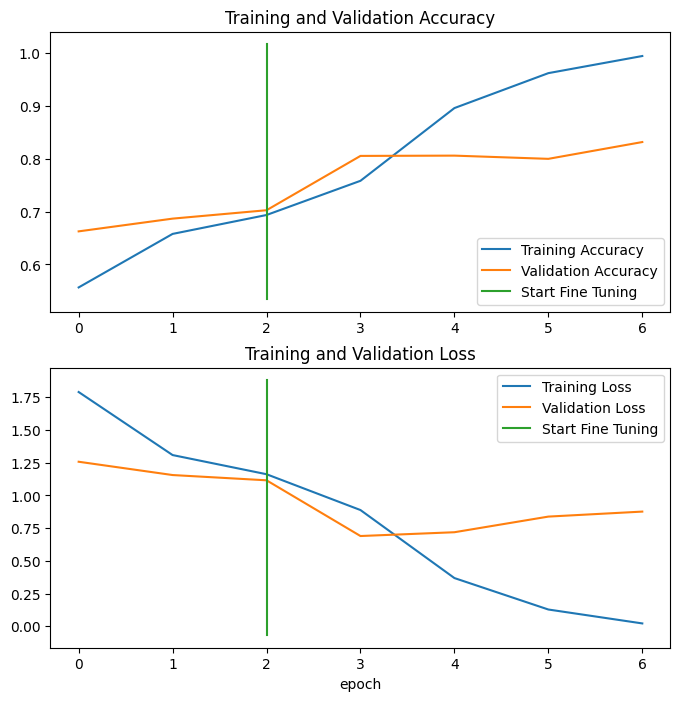

In [ ]:
# Compare the histories of feature extraction model with fine-tuning
compare_historys(original_history = history_101_food_classes_feature_extract_b4,
                new_history = history_loaded_model_fine_tune_b4,
                 initial_epochs=3)

## Visualization model results

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                                    as_supervised=True, # data gets returned in tuple format (data, label),
                                                    with_info=True)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=(224)):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channel]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple


In [ ]:
# Map preprocessing function to trainig
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data and turn it into batches and prefetch it
train_data = train_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
loaded_model_fine_tuned.evaluate(test_data)

790/790 [==============================] - 61s 77ms/step - loss: 0.8404 - accuracy: 0.7816


[0.8404306769371033, 0.7815841436386108]

In [ ]:
pred_probs = loaded_model_fine_tuned.predict(test_data, verbose=1)

790/790 [==============================] - 60s 76ms/step


In [ ]:
pred_probs_NetB4 = loaded_modelb4.predict(test_data, verbose=1)

790/790 [==============================] - 92s 100ms/step


In [ ]:
pred_probs[0]

array([1.06011191e-03, 6.79953205e-09, 4.69293667e-07, 9.60905808e-08,
       2.02265483e-06, 5.40153735e-07, 3.06478909e-09, 8.34849416e-08,
       4.22570854e-03, 2.12418545e-05, 8.73598619e-05, 1.18158139e-09,
       1.23197169e-04, 1.44032063e-04, 1.47447689e-04, 9.53427914e-08,
       2.40773614e-03, 1.37725612e-03, 6.06948589e-11, 5.48659955e-07,
       3.54775070e-10, 2.76546692e-04, 2.17064007e-04, 3.55734119e-05,
       3.77088099e-07, 2.56611656e-08, 2.22145195e-06, 3.93761766e-05,
       4.91815513e-07, 8.69438052e-01, 3.40874144e-03, 1.27107851e-04,
       7.46782458e-09, 2.10956990e-12, 9.17450408e-04, 6.83846868e-10,
       2.20880338e-05, 1.63112297e-08, 2.38686026e-09, 1.03090144e-07,
       2.90779099e-08, 5.46357715e-09, 6.08771050e-04, 2.18570606e-10,
       3.06478909e-09, 2.42698267e-02, 4.97464425e-09, 3.56806702e-11,
       3.00640806e-07, 3.48749467e-07, 3.24387521e-08, 3.56270000e-08,
       2.22948060e-08, 3.44065188e-06, 2.03302323e-11, 4.54855012e-07,
      

In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10], len(pred_classes)

(array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100]), 25250)

In [ ]:
# Get the pred classes of each label for B4
pred_classes_NetB4 = pred_probs.argmax(axis=1)
pred_classes_NetB4[:10], len(pred_classes_NetB4)

(array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100]), 25250)

In [ ]:
len(test_data)

790

In [ ]:
# To get our test labels we need  to unravel our test_data BatchDataset
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10] , len(y_labels)

([29, 81, 91, 53, 97, 97, 10, 31, 3, 100], 25250)

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


**EfficientNetB0_fine_tuned confusion matrix**

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

**EfficientNetB4 confusion matrix**

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes_NetB4,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56       250
           1       0.77      0.72      0.75       250
           2       0.82      0.82      0.82       250
           3       0.80      0.81      0.81       250
           4       0.70      0.70      0.70       250
           5       0.64      0.67      0.65       250
           6       0.83      0.81      0.82       250
           7       0.87      0.90      0.89       250
           8       0.65      0.59      0.62       250
           9       0.79      0.67      0.73       250
          10       0.72      0.67      0.69       250
          11       0.83      0.83      0.83       250
          12       0.83      0.81      0.82       250
          13       0.75      0.77      0.76       250
          14       0.72      0.75      0.74       250
          15       0.65      0.68      0.66       250
          16       0.67      0.62      0.64       250
          17       0.80    

In [ ]:
# Get a dictionary of the classificationr reprt
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict_NetB4 = classification_report(y_labels, pred_classes_NetB4, output_dict=True)
classification_report_dict

{'0': {'precision': 0.5573122529644269,
  'recall': 0.564,
  'f1-score': 0.5606361829025844,
  'support': 250},
 '1': {'precision': 0.7735042735042735,
  'recall': 0.724,
  'f1-score': 0.7479338842975206,
  'support': 250},
 '2': {'precision': 0.8207171314741036,
  'recall': 0.824,
  'f1-score': 0.8223552894211578,
  'support': 250},
 '3': {'precision': 0.7992125984251969,
  'recall': 0.812,
  'f1-score': 0.8055555555555556,
  'support': 250},
 '4': {'precision': 0.7, 'recall': 0.7, 'f1-score': 0.7, 'support': 250},
 '5': {'precision': 0.6423076923076924,
  'recall': 0.668,
  'f1-score': 0.6549019607843137,
  'support': 250},
 '6': {'precision': 0.8319672131147541,
  'recall': 0.812,
  'f1-score': 0.8218623481781376,
  'support': 250},
 '7': {'precision': 0.872093023255814,
  'recall': 0.9,
  'f1-score': 0.8858267716535433,
  'support': 250},
 '8': {'precision': 0.6475770925110133,
  'recall': 0.588,
  'f1-score': 0.6163522012578616,
  'support': 250},
 '9': {'precision': 0.79245283018

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary itmes
for k, v in classification_report_dict.items():
  if k =="accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.5606361829025844,
 'baby_back_ribs': 0.7479338842975206,
 'baklava': 0.8223552894211578,
 'beef_carpaccio': 0.8055555555555556,
 'beef_tartare': 0.7,
 'beet_salad': 0.6549019607843137,
 'beignets': 0.8218623481781376,
 'bibimbap': 0.8858267716535433,
 'bread_pudding': 0.6163522012578616,
 'breakfast_burrito': 0.7272727272727274,
 'bruschetta': 0.6943866943866944,
 'caesar_salad': 0.828,
 'cannoli': 0.8185483870967741,
 'caprese_salad': 0.7603960396039603,
 'carrot_cake': 0.7362204724409448,
 'ceviche': 0.6627450980392158,
 'cheesecake': 0.6403326403326403,
 'cheese_plate': 0.7910750507099392,
 'chicken_curry': 0.6760563380281691,
 'chicken_quesadilla': 0.7975460122699386,
 'chicken_wings': 0.8548387096774194,
 'chocolate_cake': 0.692,
 'chocolate_mousse': 0.5859375,
 'churros': 0.845691382765531,
 'clam_chowder': 0.8674698795180723,
 'club_sandwich': 0.8359375000000001,
 'crab_cakes': 0.6692913385826772,
 'creme_brulee': 0.8549019607843137,
 'croque_madame': 0.838056680

In [ ]:
# Create empty dictionary
class_f1_scores_NetB4 = {}
# Loop through classification report dictionary itmes
for k, v in classification_report_dict_NetB4.items():
  if k =="accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores_NetB4[class_names[int(k)]] = v["f1-score"]

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores_NetB4 = pd.DataFrame({"class_names": list(class_f1_scores_NetB4.keys()),
                         "f1-score": list(class_f1_scores_NetB4.values())}).sort_values("f1-score", ascending=False)

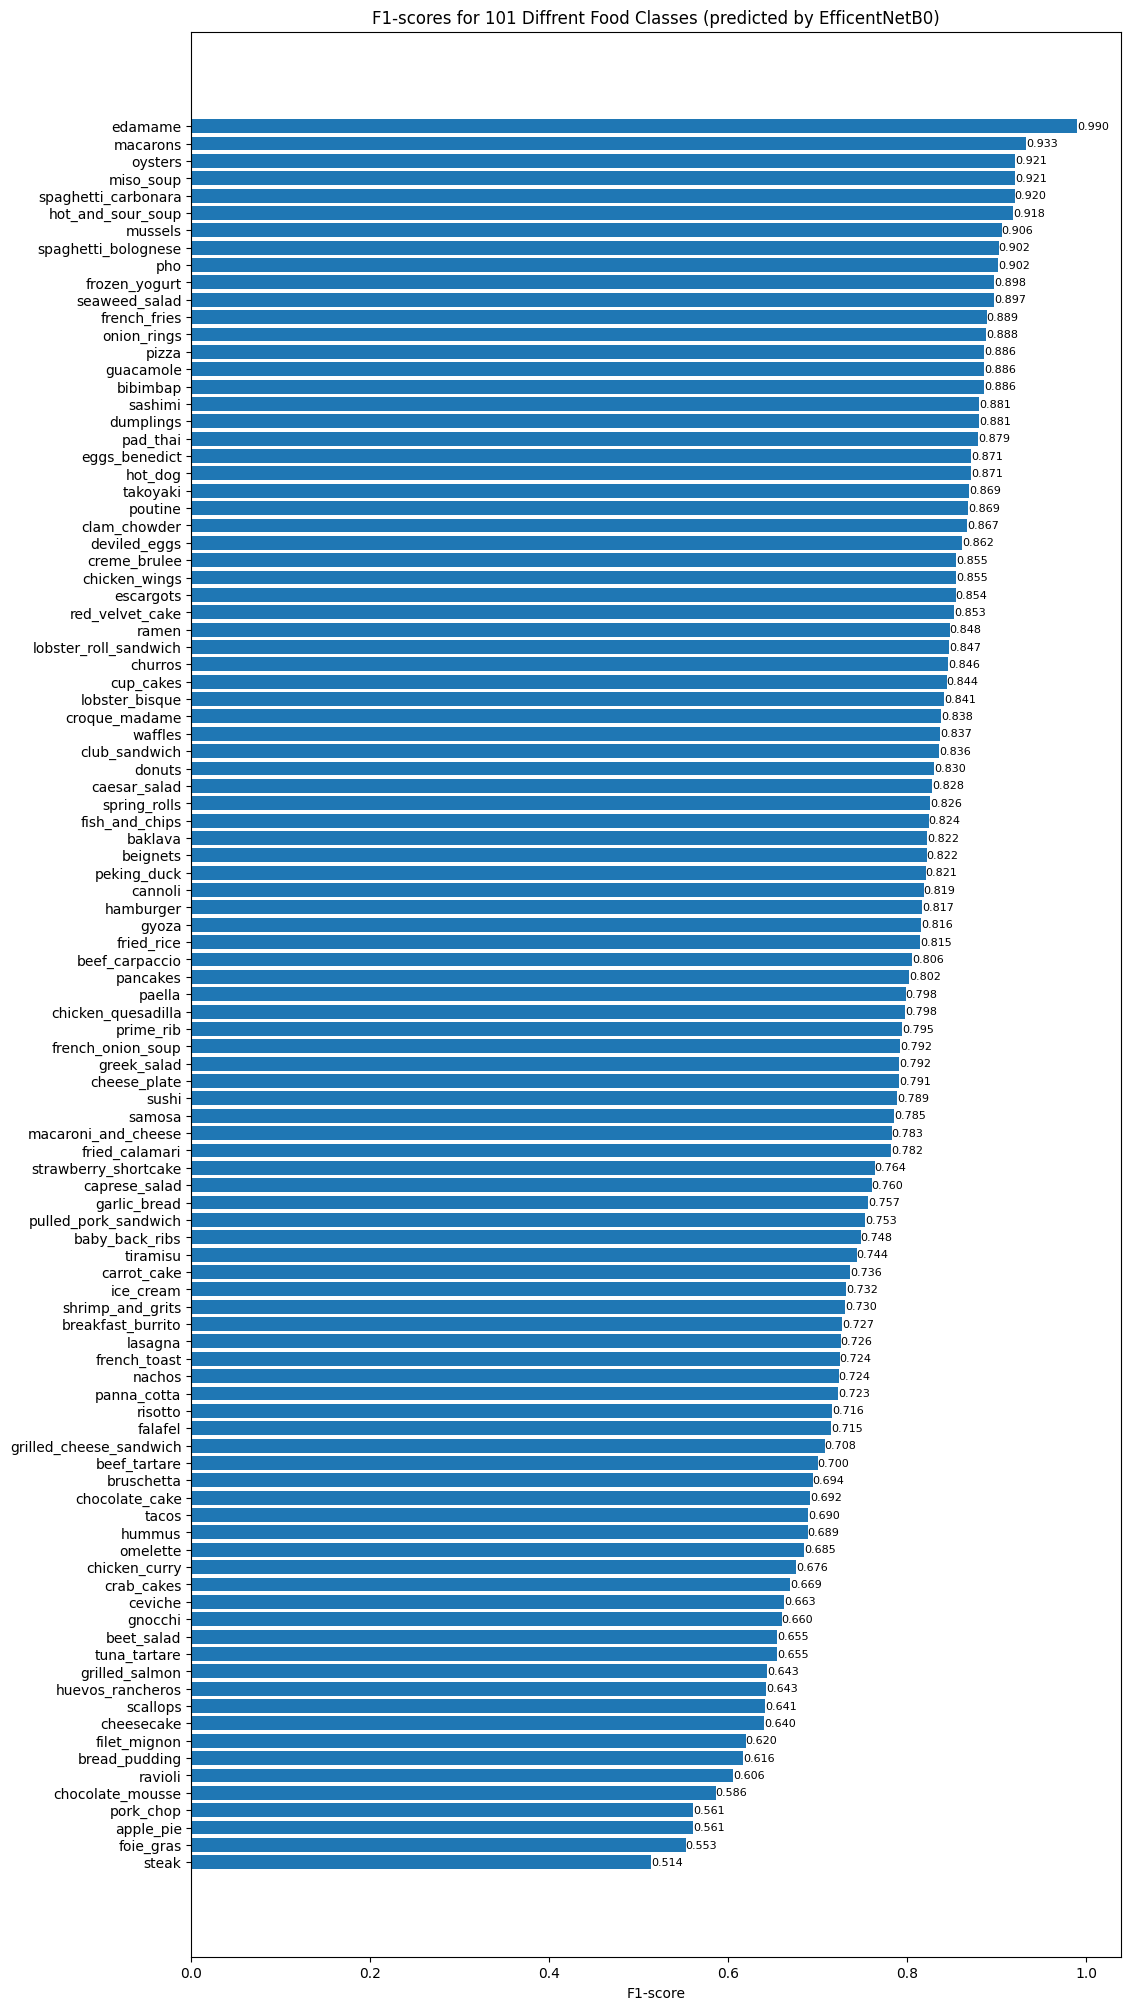

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-scores values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Diffrent Food Classes (predicted by EfficentNetB0)")
ax.invert_yaxis()

ax.bar_label(ax.containers[0],size=8,fmt='%.3f');

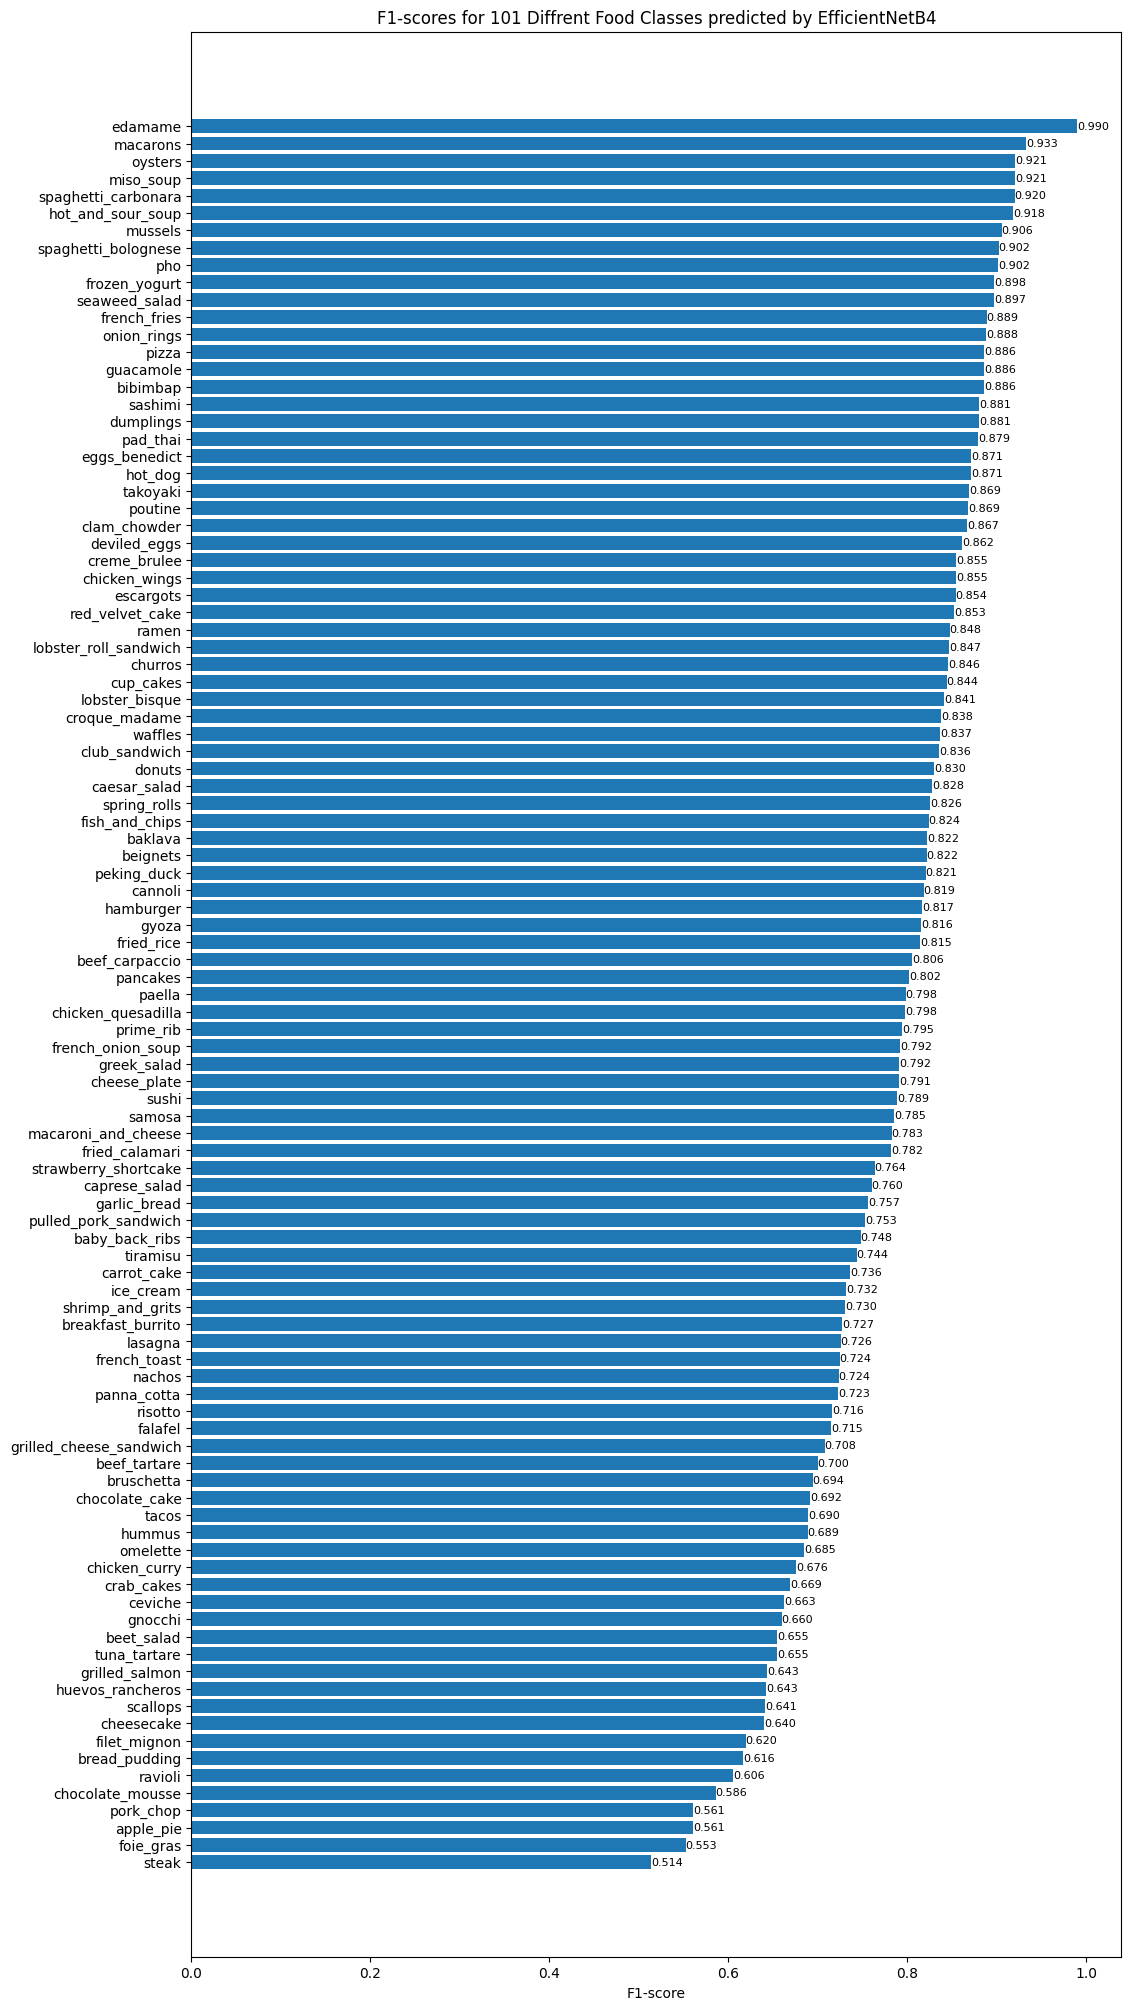

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-scores values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Diffrent Food Classes predicted by EfficientNetB4")
ax.invert_yaxis()

ax.bar_label(ax.containers[0],size=8,fmt='%.3f');